# Generate Handwritten digit images form MNIST Dataset using VAE
The variational Auto-Encoder is a type of neural network
that consists of two neural networks - encoder and a decoder
where the encoder applies some transformations to map the
input data into lower dimensions and the decoder tries to
recreate the input from this data where both encoder and
decoder have their own set of learning parameters.
• Encoder - The encoder has encoding parameters θ, which
maps the high dimensional input data into a low dimensional
latent variable representation z through the
probability distribution n pθ(z/x). It has its own weights
and bias.
• Decoder - The decoder has decoding parameters ϕ ,
which map the low dimensional latent variable back to
the high-dimensional feature space. It generates the new
reconstructed data xˆ by p ϕ(x/z) and z.


# Import the necessary libraries and load the data

We import the necessary libraries:
* **numpy** - the numerical computing library to provide mathematical operations on arrays \
* **keras** - high level neural network API for training the deep learning models \
* **tensorflow** - open-source library for mchine learning and deep learning \


**MNIST** is a well known dataset for handwritten digitd which we use to train our model to generate new handwritten digit images.

In [ ]:
from keras.layers import Lambda, Input, Dense, Conv2D, Flatten, Conv2DTranspose, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
%matplotlib inline

In [ ]:
(x_train_data, y_train_data), (x_test_data, y_test_data) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
image_size = x_train_data.shape[1]
original_dim = image_size * image_size

x_train_data = np.reshape(x_train_data, [-1, original_dim])
x_test_data = np.reshape(x_test_data, [-1, original_dim])

x_train_data = x_train_data.astype('float32') / 255
x_test_data = x_test_data.astype('float32') / 255

input_shape = (original_dim, )
batch_size = 128
print(input_shape)

(784,)


In [ ]:
def latent_sampling(args):
    z_mean_layer, z_log_var_layer = args
    batch = K.shape(z_mean_layer)[0]
    dimension = K.int_shape(z_mean_layer)[1]
    ep = K.random_normal(shape=(batch, dimension))
    return z_mean_layer + K.exp(0.5 * z_log_var_layer) * ep

## Encoder Network:
In the Variational Autoencoder
(VAE), the encoder network is responsible for mapping
high-dimensional input data into a lower-dimensional latent
space. This is achieved by using hidden layers that applies
a nonlinear transformation to the input data to extract its
underlying features. The output of the encoder is a set of
parameters that define a Gaussian probability distribution in
the latent space. These parameters represent the mean and
variance of the distribution, and they are used to sample the
latent space in a stochastic manner.
To improve the performance of the encoder, we
experimented with two different architectures: one that
uses only ReLU hidden layers and another that uses a
combination of Conv2D and ReLU layers. The Conv2D
layers allow the encoder to capture spatial features in the
input data, while the ReLU layers help to extract higherlevel
features. By comparing the performance of these two
architectures, we can determine which one is better suited for
encoding MNIST images.

In [ ]:
from tensorflow.python.ops.gen_array_ops import shape
hidden_node = 256
latent_node = 16
# img_shape = (28, 28, 1)

# build encoder model
# input layer
encoder_inputs = Input(shape=input_shape, name='input_encoder')

# # encoder architecture 1 - dense hidden layers
encoder_hidden = Dense(hidden_node, activation='relu')(encoder_inputs)
z_mean = Dense(latent_node, name='z_mean')(encoder_hidden)
z_log_var = Dense(latent_node, name='z_log_var')(encoder_hidden)

# # encoder architecture 2 -  adding conv2D layers
# x = Reshape((28, 28, 1))(encoder_inputs)
# x = Conv2D(32, 3, padding='same', activation='relu')(x)
# x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
# # x = Conv2D(64, 3, padding='same', activation='relu')(x)
# # x = Conv2D(64, 3, padding='same', activation='relu')(x)
# shape_before_flattening = K.int_shape(x)
# x = Flatten()(x)
# x = Dense(16, activation="relu")(x)
# z_mean = Dense(latent_node, name="z_mean")(x)
# z_log_var = Dense(latent_node, name="z_log_var")(x)
#----------------------------------------------


# normalize log variance to std dev
z = Lambda(latent_sampling, output_shape=(latent_node,), name='z')([z_mean, z_log_var])
# instantiate encoder model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_encoder (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_encoder[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 16)           4112        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 16)           4112        ['dense[0][0]']                  
                                                                                            

## Decoder Network

The decoder takes the encoded latent
representation of a digit as input and reLu activation and
sigmoid activation layers are added to the neural net for the
model to be able to decode the samples.They produce the
784 Bernoulli parameters, one for each of the 784 pixels
in the image. However, as the decoder has access only to
a summary of the information and not the entire data, it is
not able to perfectly reconstruct the input of the encoder.
The hidden layers allow the decoder to learn the underlying
distribution of the input data and generate a new sample from
that distribution, which is then used as the output. This process
is based on the principle of maximum likelihood estimation,
where the goal is to find the parameters of a distribution that
maximize the likelihood of generating the observed data. By
using the dense ReLU and sigmoid layers, we are able to
achieve a relatively high degree of accuracy in reconstructing
the input data, despite the loss of some information due to the
summarization of the latent representation.

In [ ]:
# build decoder model
latent_decoder_inputs = Input(shape=(latent_node,), name='latent_sampling')

# decoder architecture 1 - dense hidden layers
# decoder_hidden = Dense(hidden_node, activation='relu')(latent_decoder_inputs)
# decoder_outputs = Dense(original_dim, activation='sigmoid')(decoder_hidden)

# encoder architecture 2 - adding conv2DTranspose layers
decoder_hidden = Dense(units=7*7*32, activation='relu')(latent_decoder_inputs)
decoder_hidden = Reshape(target_shape=(7, 7, 32))(decoder_hidden)
decoder_hidden = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',activation='relu')(decoder_hidden)
decoder_hidden = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same',activation='relu')(decoder_hidden)
decoder_hidden = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')(decoder_hidden)
flatten_layer = Flatten()(decoder_hidden)
decoder_outputs = Dense(original_dim, activation='sigmoid')(flatten_layer)
#-------------

# instantiate decoder model
decoder = Model(latent_decoder_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_sampling (InputLayer  [(None, 16)]             0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 1568)              26656     
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       18496     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                           

### instantiate VAE model

The VAE is trained using maximum likelihood
estimation (MLE) with an additional KL divergence
regularization term. The training process involves minimizing
the negative log-likelihood of the data under the model,
which is equivalent to maximizing the evidence lower bound
(ELBO) objective. The ELBO is defined as the sum of the
reconstruction loss and the KL divergence between the learned
latent distribution and the prior distribution. The crucial point
of VAEs is to learn an encoder that can aggregate posterior
distribution q(z) = ED[q(z/x)] close to the prior p(z). This
is monitored by the loss function of the VAE. In VAE,
the reconstruction error between the input data x and the
encoded-decoded data d(e(x)) is represented as (d(e(x))). The
dimensionality reduction problem here can be written as:
(e∗, d∗) = argmin(e, d)inE ∗ D(d(e(x))) (1)
This reconstruction error is back propagated to the network,
after it is reparameterized.

In [ ]:
# instantiate VAE model

model_outputs = decoder(encoder(encoder_inputs)[2])
vae = Model(encoder_inputs, model_outputs, name='vae_mlp')

reconstruction_loss = binary_crossentropy(encoder_inputs, model_outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_encoder (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 16),         209184      ['input_encoder[0][0]']          
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                                  
 decoder (Functional)           (None, 784)          679345      ['encoder[0][2]']                
                                                                                            

In [ ]:
def train_model(model):
    trained_model = model.fit(x_train_data, epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test_data, None))
    return trained_model

In [ ]:
def plot_latent_space(encoder):
    z_test, _, _ = encoder.predict(x_test_data, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test_data)
    plt.colorbar()
    plt.xlabel("Z[0]")
    plt.ylabel("Z[1]")
    plt.savefig("VAE")
    plt.show()

In [ ]:
def plot_vae_output(decoder,latent_dim):
    n = 1
    digit_num = 28
    figure = np.zeros((digit_num * n, digit_num * n))
    axis_x = np.linspace(-3, 3, n)
    axis_y = np.linspace(-3, 3, n)[::-1]
    for i, yi in enumerate(axis_y):
        for j, xi in enumerate(axis_x):
            if(latent_dim == 2):
                latent_sample = np.array([[xi, yi]*int(latent_dim/2)])
            else:
                latent_sample = np.random.normal(0,1,size=[batch_size, latent_dim])
            input_decoded = decoder.predict(latent_sample)

            digit = input_decoded[0].reshape(digit_num, digit_num)
            figure[i * digit_num: (i + 1) * digit_num,
                   j * digit_num: (j + 1) * digit_num] = digit

    plt.figure(figsize=(10, 8))
    i_range = digit_num // 2
    j_range = (n - 1) * digit_num + i_range + 1
    pixel_range = np.arange(i_range, j_range, digit_num)
    sample_range_x = np.round(axis_x, 1)
    sample_range_y = np.round(axis_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.imshow(figure, cmap='gray')
    plt.savefig("VAE_Output")
    plt.show()

Train the model and plot the results.

In [ ]:
epochs = 500
trained_model = train_model(vae)
plot_latent_space(encoder)
plot_vae_output(decoder, latent_node)

Epoch 1/500
469/469 [==============================] - 115s 240ms/step - loss: 179.9852 - val_loss: 134.0219
Epoch 2/500
469/469 [==============================] - 111s 237ms/step - loss: 122.7176 - val_loss: 115.1915
Epoch 3/500
469/469 [==============================] - 109s 233ms/step - loss: 113.5444 - val_loss: 110.4667
Epoch 4/500
469/469 [==============================] - 117s 250ms/step - loss: 110.1329 - val_loss: 108.3895
Epoch 5/500
469/469 [==============================] - 109s 233ms/step - loss: 108.3438 - val_loss: 106.5858
Epoch 6/500
469/469 [==============================] - 110s 234ms/step - loss: 107.0303 - val_loss: 105.7444
Epoch 7/500
469/469 [==============================] - 111s 237ms/step - loss: 106.0607 - val_loss: 105.1544
Epoch 8/500
469/469 [==============================] - 110s 234ms/step - loss: 105.2999 - val_loss: 104.7648
Epoch 9/500
469/469 [==============================] - 106s 226ms/step - loss: 104.6146 - val_loss: 104.0237
Epoch 10/500
469/46

4/4 [==============================] - 0s 2ms/step


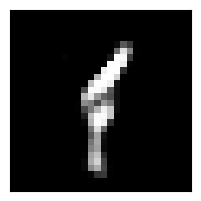

4/4 [==============================] - 0s 3ms/step


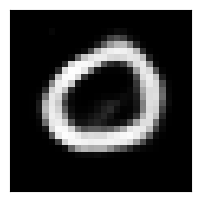

4/4 [==============================] - 0s 3ms/step


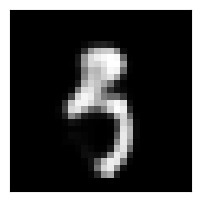

4/4 [==============================] - 0s 3ms/step


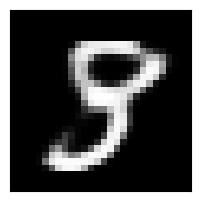

4/4 [==============================] - 0s 3ms/step


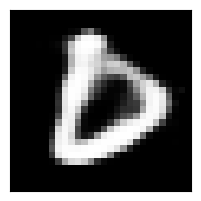

4/4 [==============================] - 0s 6ms/step


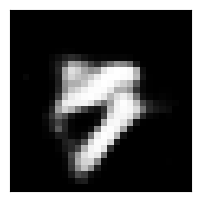

4/4 [==============================] - 0s 3ms/step


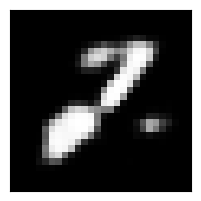

In [ ]:
plt.plot(trained_model.history['loss'], label='Training Loss')
plt.plot(trained_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()